# Imbalanced classes — pre-processing

One approach to dealing with the imbalanced data is to alter the data before you apply the model. In this way the model itself does not need to be tweaked, you just feed it a processed version of the data.

These approaches can be roughly slight into:
- altering the number of data points (such as through undersampling, oversampling or creating synthetic data points)
- changing the labels of the training data (i.e. the MetaCost algorithm)
- ensemble methods (where you train a series of classifiers on balanced subsets of the data)

(Technically the ensemble methods go slightly beyond adjusting the training data, you also produce a series of models that vote on which class to predict but the individual classifiers within the ensemble have not been adjusted to account for imbalances in the data.

Other approaches to pre-processing the data do exist but the ones discussed above are the building blocks that demonstrate the central principles that others combine and build upon.

In this notebook I will quickly outline these different approaches with some basic examples using the same toy dataset that was introduced in the other notebooks.

In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import EasyEnsemble
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, classification_report

# Define a function for plotting data.
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.5)
    plt.show()

## Example problem

The simple example dataset is again used.

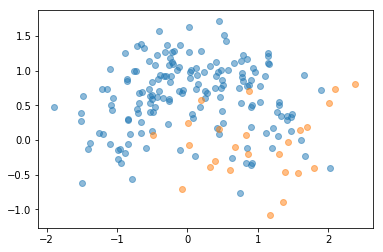

In [2]:
# Based on the imbalance_learn package examples
X, y = make_moons(n_samples=500, shuffle=True, noise=0.4, random_state=40)
X_, y_ = make_imbalance(X, y, ratio=0.15, min_c_=1, random_state=40)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=40, stratify=y_)
plot_data(X_train, y_train)

The data can be split into training and test sets and then a support vector machine (SVM) is fitted. F1-score can then be used to look at the efficacy of the model.

In [3]:
# Define and fit model
model = SVC(random_state=40, probability=True)
model.fit(X_train, y_train)

# Make predictions
y_predict = model.predict(X_test)

# Output the precision, recall and f1-score
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       0.91      1.00      0.95        83
          1       1.00      0.33      0.50        12

avg / total       0.92      0.92      0.90        95



## Oversampling and undersampling

Undersampling (also called downsampling) involves reducing the number of data points in the majority place and oversampling (also called upsampling) involves increasing the number of data points in the minority class. The aim is to either increase or decrease the classes until they are of approximately equal size.

The simpliest form of undersampling is to randomly select a subset of the majority class to keep and the rest are discarded. More advances forms exist which involve analysising the dataset with a model (normally nearest neighbours) and either remove noise from the majority class by identified points which are likely to have been misclassified or they pick the data points in the majority class which are closest to the decision boundary so are most likely to determine this boundary.

The simplies form of oversamply is to randomly select points from within the minority class and then duplicate them. More advanced techniques exist which instead of duplicating points in the minority class synthetic data points are created. These are discussed further later on.

Below random oversampling and random undersampling are demonstrated using rountines from the *imbalanced-learn* package for python (the shortened form of the name is *imblearn*). Such simple techniques can instead be coded by hand by using various sampling functions provided by various python objects; however, as _imblearn_ also contains the more advanced techniques it has been used here.

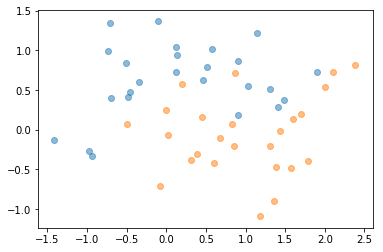

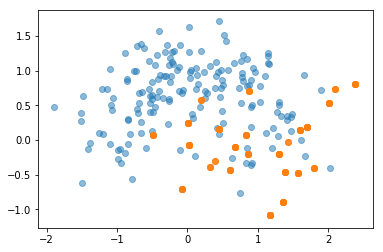

In [4]:
under = RandomUnderSampler(random_state=40)
over = RandomOverSampler(random_state=40)

X_usamp, y_usamp = under.fit_sample(X_train, y_train)
X_osamp, y_osamp = over.fit_sample(X_train, y_train)

plot_data(X_usamp, y_usamp)
plot_data(X_osamp, y_osamp)

At first sight the oversampling graph looks like nothing has happened, but the orange dots are darker because now there are multiple datapoints with the exact same pictures.

Models can then be built using these samples. One thing that is really important to remember is that the train/test split should be done before oversampling, otherwise information about the test set could be included in the training set (as data has been duplicated). Similarily, if crossvalidation is being used the oversampling should be done within each fold rather than before-hand, otherwise you will end up with overfitting that you might not notice.

Here we fit a support vector machine to the undersampled data.

In [5]:
model_u = SVC(random_state=40, probability=True)
model_u.fit(X_usamp, y_usamp)

y_upredict = model_u.predict(X_test)

print "Number of data points:", len(X_usamp)
print ""
print classification_report(y_true=y_test, y_pred=y_upredict)

Number of data points: 50

             precision    recall  f1-score   support

          0       1.00      0.77      0.87        83
          1       0.39      1.00      0.56        12

avg / total       0.92      0.80      0.83        95



Performance on the majority class has fallen and perfromance on the minority class has improved. One drawback of undersampling is that you lose information about the majority class and you have a smaller dataset. Model performance is strongly influenced by the amount of data present, and here undersampling has resulted in a very small dataset.

Next, let's fit the same model to the oversampled data.

In [6]:
model_o = SVC(random_state=40, probability=True)
model_o.fit(X_osamp, y_osamp)

y_opredict = model_o.predict(X_test)

print classification_report(y_true=y_test, y_pred=y_opredict)

             precision    recall  f1-score   support

          0       1.00      0.75      0.86        83
          1       0.36      1.00      0.53        12

avg / total       0.92      0.78      0.81        95



On this dataset oversampling has performed worse than undersampling, but this would be problem specific. However, performance on the minority class is still better than it was when the model was fitted on the original, imbalanced data.

## Synthetic data

The use of synthetic data using techniques such as SMOTE, is a form of oversampling. With SMOTE, instead of duplicating data points belonging to the minority class it draws lines between neighbouring points and creates new data points along these lines.

Typically SMOTE is accompanied by noise reducing undersampling techinques such as Tomek link removal. Below a combined SMOTE-Tomek model.

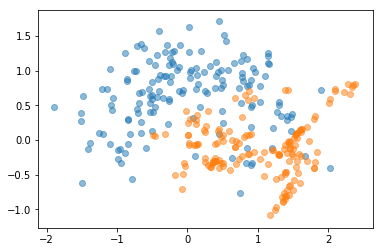

In [7]:
syn = SMOTETomek(random_state=40, smote=SMOTE(k_neighbors=10))

X_syn, y_syn = syn.fit_sample(X_train, y_train)

plot_data(X_syn, y_syn)

It is much clearer in this graph that oversampling has occured than with random oversampling.

Let's fit the SVM model from before.

In [8]:
model_syn = SVC(random_state=40, probability=True)
model_syn.fit(X_syn, y_syn)

y_spredict = model_syn.predict(X_test)

print classification_report(y_true=y_test, y_pred=y_spredict)

             precision    recall  f1-score   support

          0       1.00      0.75      0.86        83
          1       0.36      1.00      0.53        12

avg / total       0.92      0.78      0.81        95



In this example very similiar performance to random oversampling was achieved, but this is just a very simple example.

## MetaCost

Domingos introduced the MetaCost algorthim<sup>[1]</sup>s. This approach is interesting as instead of balancing the data by altering the number of points, we make the data more balanced by altering the labels. At first this can seem change as the labels are part of the ground truth we are trying to learn, but as you will see it does have a firm theoretical grounding.

First we use the theory of cost sensitive classifiers to define a probability threshold for the two class problem we have been considering (see the introduction for more details).

[1]:https://homes.cs.washington.edu/~pedrod/papers/kdd99.pdf

In [9]:
c01_c10 = (y_==0).sum() / (y_==1).sum()

threshold = 1 / (1 + c01_c10)

# Function to use this threshold when making predictions
def make_prediction(data, model, threshold):
    probs = model.predict_proba(data)
    return [1 if prob[1] > threshold else 0 for prob in probs]

For this example we will use the original model that was fitted to the imbalanced data at the very start. This classinfier can be applied to the _training_ data to work out the probability that each training point belongs to the minority class.

Points in the training data have been given a class, not a probability though due to noise we may not be 100% certaini that any given point belongs to the right class. Even if all the points in the training have been correctly assigned to their _most likely_ class the theory of cost sensitive classifiers says that they should have instead been assigned to the classes which result in the _lowest classification cost_.

Using the original classifier we can generate the probabilites that the training data belong to the minority class and then use the threshold above to correct the classes to account for classification costs. Then a new model can be fitted on the corrected labels.

This is done below.

In [10]:
y_new = make_prediction(X_train, model, threshold)

# Define and fit model
model = SVC(random_state=40, probability=True)
model.fit(X_train, y_new)

# Make predicts
y_predict = model.predict(X_test)

# Output the precision, recall and f1-score
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       0.97      0.92      0.94        83
          1       0.59      0.83      0.69        12

avg / total       0.93      0.91      0.91        95



This results in a small overall improvement over the original model but a huge improvement in the predictions of the minority class.

The full MetaCost algorthim is more complicated. A series of subsets of the training data are created and a model is fitted to each one. This produces an ensemble of models and the probability for a given data point is taken to be the average of the probabilities produced by each model. The idea is that using an ensemble approach improves the accuracy of the generated probabilities, and these are vital to produce the corrected labels.

Once the labels have been created a single model is then trained on the corrected data and is used for predicition.

This is demonstrated below for the two class case.

In [11]:
# Function for calculating the mean
def mean(x):
    return sum(x)/len(x)

# Define a splitting function
sss = StratifiedShuffleSplit(n_splits=2, random_state=40)

models_probs = []

# Loop over each sub sample
for x in sss.split(X_train, y_train):
    
    # Extract the X and y samples
    X_samp = X_train[x[0]]
    y_samp = y_train[x[0]]
    
    # Fit the model
    model = model.fit(X_samp, y_samp)
    
    # Produce probabilities
    prob_both = model.predict_proba( X_train )
    
    # Only keep minority probabilities
    prob_1 = [prob[1] for prob in prob_both]
    
    models_probs.append(prob_1)


# Get the mean probability for the training classes
probs = map(mean, zip(*models_probs))

# Predict the classes
classes = [1 if prob > threshold else 0 for prob in probs]

# Train model on new classes
model = model.fit(X_train, classes)

# Make predictions
y_predict = model.predict(X_test)
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       0.97      0.93      0.95        83
          1       0.62      0.83      0.71        12

avg / total       0.93      0.92      0.92        95



This has lead to a small improvement.

## Balanced ensembles

Ensemble approaches such as bagging and boosting are popular methods for classification as they often produce more accurate results. However, arguably they are more sensitive to imbalanced data because if they do not use stratified sampling many of the subsets they consider may not contain much (or any) information about the minority class.

One way of extending ensemble based approaches to work with imbalanced data is to ensure that each subsample used in the ensemble is balanced. The _imblearn_ package contains a function for creating balanced ensembles, and it also contains a more intelligent version that chooses the more important data points from the majority class.

Here the simple balanced subset technique is demonstrated.

In [12]:
# Define an ensemble function
ee = EasyEnsemble(n_subsets=3, random_state=40)
X_ee, y_ee = ee.fit_sample(X_train, y_train)

models = []

# Loop over each sub sample
for x in xrange(0, len(X_ee)):
    
    # Extract the X and y samples
    X_samp = X_ee[x]
    y_samp = y_ee[x]
    
    # Fit the model
    model = model.fit(X_samp, y_samp)
    models.append(model)
    
def ensemble_prediction(X_test, models):
    
    predictions = []
    for model in models:
        predict = model.predict(X_test)
        predictions.append(predict)
    
    y_predict = map(mean, zip(*predictions))
    y_predict = [1 if y>=0.5 else 0 for y in y_predict]
    
    return y_predict

print "Size of each subset:", len(X_samp)
print ""

# Make predictions
y_predict = ensemble_prediction(X_test, models)
print classification_report(y_true=y_test, y_pred=y_predict)

Size of each subset: 50

             precision    recall  f1-score   support

          0       1.00      0.77      0.87        83
          1       0.39      1.00      0.56        12

avg / total       0.92      0.80      0.83        95



Which is an improvement for the minority class (over the original model) but not for the majority class. The _imblearn_ package also has this functionality built into a wrapper function so that you do not need to write so many lines of code.

In [13]:
model = BalancedBaggingClassifier(base_estimator=SVC(random_state=40, probability=True))

model.fit(X_train, y_train)

# Make predicts
y_predict = model.predict(X_test)
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       1.00      0.75      0.86        83
          1       0.36      1.00      0.53        12

avg / total       0.92      0.78      0.81        95



In this example we do not have a lot of data so each subset is quite small.